<a href="https://colab.research.google.com/github/pesfahanian/Kaggle_Pneumonia_InceptionV3/blob/main/Kaggle_Pneumonia_DenseNetipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%cd /content/drive/MyDrive/Pneumonia/chest_xray

/content/drive/MyDrive/Pneumonia/chest_xray


In [ ]:
!ls

 EfficientNet2.h5  'InceptionV3-(1).h5'   __MACOSX	   test
 EfficientNet.h5   'InceptionV3-(2).h5'   model_vgg16.h5   train
 foo.pdf	    InceptionV3.h5	  pneumonia.h5	   val


In [ ]:
import glob
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

import itertools
from itertools import cycle

from sklearn import metrics
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_curve

import keras_preprocessing
from keras.layers import Input
from keras.models import load_model
from keras_preprocessing import image
from keras.callbacks import ModelCheckpoint
from keras.applications.densenet import DenseNet121
from keras_preprocessing.image import ImageDataGenerator

In [ ]:
train_path      =   '/content/drive/MyDrive/Pneumonia/chest_xray/train'
validation_path =   '/content/drive/MyDrive/Pneumonia/chest_xray/val'
test_path       =   '/content/drive/MyDrive/Pneumonia/chest_xray/test'

In [ ]:
train_NORMAL = len(glob.glob(train_path + '/NORMAL/*'))
train_PNEUMONIA = len(glob.glob(train_path + '/PNEUMONIA/*'))

validation_NORMAL = len(glob.glob(validation_path + '/NORMAL/*'))
validation_PNEUMONIA = len(glob.glob(validation_path + '/PNEUMONIA/*'))

test_NORMAL = len(glob.glob(test_path + '/NORMAL/*'))
test_PNEUMONIA = len(glob.glob(test_path + '/PNEUMONIA/*'))

print('Train:', train_NORMAL, 'NORMAL,', train_PNEUMONIA, 'PNEUMONIA.')
print('Validation:', validation_NORMAL, 'NORMAL,', validation_PNEUMONIA, 'PNEUMONIA.')
print('Test:', test_NORMAL, 'NORMAL,', test_PNEUMONIA, 'PNEUMONIA.')

Train: 1300 NORMAL, 3834 PNEUMONIA.
Validation: 49 NORMAL, 49 PNEUMONIA.
Test: 234 NORMAL, 390 PNEUMONIA.


In [ ]:
IMG_SIZE    =   224
num_classes =   2
epochs      =   15
batch_size  =   16

In [ ]:
train_datagen = ImageDataGenerator(rescale          =   1./255,
                                   rotation_range   =   15,     # changed this
                                   shear_range      =   0.2,    # changed this
                                   zoom_range       =   0.2,    # changed this
                                   horizontal_flip  =   False)
train_generator = train_datagen.flow_from_directory(train_path,
                                                    target_size =   (IMG_SIZE, IMG_SIZE),
                                                    class_mode  =   'categorical',
                                                    batch_size  =   batch_size,
                                                    shuffle     =   True)

validation_datagen = ImageDataGenerator(rescale = 1./255)
validation_generator = validation_datagen.flow_from_directory(validation_path,
                                                              target_size =   (IMG_SIZE, IMG_SIZE),
                                                              class_mode  =   'categorical',
                                                              batch_size  =   batch_size,
                                                              shuffle     =   False)

test_datagen = ImageDataGenerator(rescale = 1./255)
test_generator = test_datagen.flow_from_directory(test_path,
                                                  target_size =   (IMG_SIZE, IMG_SIZE),
                                                  class_mode  =   'categorical',
                                                  batch_size  =   batch_size,
                                                  shuffle     =   False)

Found 5134 images belonging to 2 classes.
Found 98 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


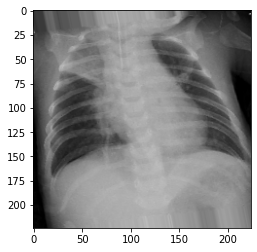

In [ ]:
x, y = train_generator.next()
for i in range(0, 1):
    image = x[i]
    plt.imshow(image)
    plt.show()

In [ ]:
input_image = Input((IMG_SIZE, IMG_SIZE, 3))
feature_extractor = DenseNet121(include_top     =   False,
                                weights         =   'imagenet',
                                input_tensor    =   input_image, 
                                input_shape     =   (IMG_SIZE, IMG_SIZE, 3),
                                pooling         =   'avg') 

29089792/29084464 [==============================] - 0s 0us/step


In [ ]:
model = tf.keras.models.Sequential(
    [
     feature_extractor,
     tf.keras.layers.Dense(64, activation='relu'),
     tf.keras.layers.Dropout(0.2),
     tf.keras.layers.Dense(64, activation='relu'),
     tf.keras.layers.Dropout(0.2),
     tf.keras.layers.Dense(num_classes, activation='softmax')
    ]
)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 1024)              7037504   
_________________________________________________________________
dense (Dense)                (None, 64)                65600     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 130       
Total params: 7,107,394
Trainable params: 7,023,746
Non-trainable params: 83,648
_________________________________________

In [ ]:
METRICS = ['accuracy',
           tf.keras.metrics.Precision(name='precision'),
           tf.keras.metrics.Recall(name='recall')]

In [ ]:
save_path = "DenseNet.h5"
checkpoint = ModelCheckpoint(save_path,
                             monitor        =   'val_accuracy',
                             verbose        =   1,
                             save_best_only =   True,
                             mode           =   'max')
callbacks = [checkpoint]

In [ ]:
model.compile(optimizer =   tf.optimizers.Adam(learning_rate=0.0001),
              loss      =   'categorical_crossentropy',
              metrics   =   METRICS )

In [ ]:
history = model.fit(train_generator,
                    epochs              =   epochs,
                    callbacks           =   [callbacks],
                    validation_data     =   validation_generator,
                    use_multiprocessing =   True,
                    workers             =   4)

Epoch 1/15
321/321 [==============================] - ETA: 0s - loss: 0.1563 - accuracy: 0.9439 - precision: 0.9439 - recall: 0.9439WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.

Epoch 00001: val_accuracy improved from -inf to 0.97959, saving model to DenseNet.h5
321/321 [==============================] - 669s 2s/step - loss: 0.1563 - accuracy: 0.9439 - precision: 0.9439 - recall: 0.9439 - val_loss: 0.0385 - val_accuracy: 0.9796 - val_precision: 0.9796 - val_recall: 0.9796
Epoch 2/15
321/321 [==============================] - ETA: 0s - loss: 0.0970 - accuracy: 0.9665 - precision: 0.9665 - recall: 0.9665WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.

Epoch 00002: val_accuracy did not improve from 0.97959
321/321 [==============================] - 102

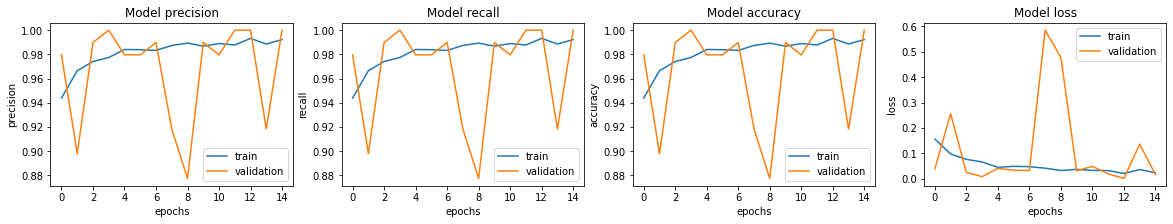

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()
for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'validation'])

In [ ]:
model.evaluate(test_generator)

39/39 [==============================] - 239s 6s/step - loss: 0.3013 - accuracy: 0.9439 - precision: 0.9439 - recall: 0.9439


[0.30127930641174316,
 0.9439102411270142,
 0.9439102411270142,
 0.9439102411270142]

In [ ]:
Y_pred = model.predict_generator(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

Instructions for updating:
Please use Model.predict, which supports generators.


In [ ]:
print('Classification Report:')
target_names = ['NORMAL', 'PNEUMONIA']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.95      0.90      0.92       234
   PNEUMONIA       0.94      0.97      0.96       390

    accuracy                           0.94       624
   macro avg       0.94      0.94      0.94       624
weighted avg       0.94      0.94      0.94       624



In [ ]:
def plot_confusion_matrix(cm,
                          classes,
                          normalize =   False,
                          title     =   'Confusion matrix',
                          cmap      =   plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes, rotation=90, va="center")

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            fontsize = 15,
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


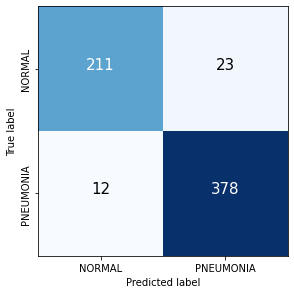

In [ ]:
cm = confusion_matrix(test_generator.classes, y_pred)
cm_plot_labels = ['NORMAL', 'PNEUMONIA']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='')